In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import anndata
import re
import h5py
import scipy.sparse as scs
import concurrent.futures
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csc_matrix
from concurrent.futures import ThreadPoolExecutor, as_completed
import umap
import random
import multiprocessing
random.seed(123)
from joblib import Parallel, delayed
import copy
import os
from tqdm import tqdm
import math
import scanpy.external as sce
from concurrent.futures import ProcessPoolExecutor

from PIL import Image, ImageDraw, ImageFont
import gc
import re
import multiprocessing

In [3]:
def run_leiden(adata, resolution, key_added):
    
    adata_copy = copy.deepcopy(adata)
    adata_clustering = sc.tl.leiden(adata_copy, resolution=resolution, key_added=key_added,n_iterations=3, copy=True)
    return adata_clustering.obs

def run_leiden_parallel(adata, tasks):
    with ProcessPoolExecutor(max_workers=5) as executor:
        futures = [executor.submit(run_leiden, copy.deepcopy(adata), resolution, key_added) for resolution, key_added in tasks]
        
        results = [future.result() for future in futures]

    for result, (_, key_added) in zip(results, tasks):
        adata.obs[key_added] = result[key_added]

    return adata

In [4]:
files = os.listdir("h5_cleaned_by_celltype/")
pattern = re.compile(r'mono')

In [5]:
adata_list=[]
for i in files:
    adata_sinlge=sc.read_h5ad("h5_cleaned_by_celltype/"+i)
    adata_list.append(adata_sinlge)
    

In [6]:
adata=anndata.concat(adata_list)

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [7]:
adata

AnnData object with n_obs × n_vars = 3732411 × 18082
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'celltype.l1', 'celltype.l1.score', 'celltype.l2', 'celltype.l2.score', 'celltype.l3', 'celltype.l3.score', 'chip_id', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pool_id', 'sampleID', 'well_id', 'celltypist_l1', 'celltypist_l2', 'celltypist_l3', 'predicted_doublet', 'doublet_score', 'age_enrollment', 'biological_sex', 'subject_guid', 'race', 'cmv_status', 'cmv_index', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden_2', 'leiden'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'

In [8]:
del adata_list
gc.collect()

51509

In [9]:
%%time

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var_names[adata.var['highly_variable']]]
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')

/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an

CPU times: user 1h 29min 46s, sys: 16min 20s, total: 1h 46min 6s
Wall time: 16min 3s


In [10]:
%%time
sce.pp.harmony_integrate(adata, 'pool_id',max_iter_harmony = 10)

2024-05-04 06:11:25,156 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-05-04 06:26:28,682 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-05-04 06:26:42,389 - harmonypy - INFO - Iteration 1 of 10
2024-05-04 06:49:50,567 - harmonypy - INFO - Iteration 2 of 10
2024-05-04 07:13:07,574 - harmonypy - INFO - Iteration 3 of 10
2024-05-04 07:36:42,504 - harmonypy - INFO - Iteration 4 of 10
2024-05-04 08:00:29,977 - harmonypy - INFO - Iteration 5 of 10
2024-05-04 08:24:37,149 - harmonypy - INFO - Iteration 6 of 10
2024-05-04 08:33:12,457 - harmonypy - INFO - Converged after 6 iterations


CPU times: user 17h 31min 36s, sys: 16h 50min 46s, total: 1d 10h 22min 23s
Wall time: 2h 21min 51s


In [11]:
%%time
sc.pp.neighbors(adata, n_neighbors=50,use_rep='X_pca_harmony', n_pcs=30)
sc.tl.umap(adata,min_dist=0.45)

/opt/conda/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


  0%|          | 0/200 [00:00<?, ?it/s]

	completed  0  /  200 epochs


IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


	completed  20  /  200 epochs
	completed  40  /  200 epochs


IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


	completed  60  /  200 epochs


IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs


IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


	completed  160  /  200 epochs
	completed  180  /  200 epochs


IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


CPU times: user 4h 27min 47s, sys: 3h 2min 5s, total: 7h 29min 53s
Wall time: 1h 51min 11s


In [12]:
adata.write_h5ad('All_processed_pre_leiden.h5ad')

In [2]:
adata=sc.read_h5ad('All_processed_pre_leiden.h5ad')

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ve

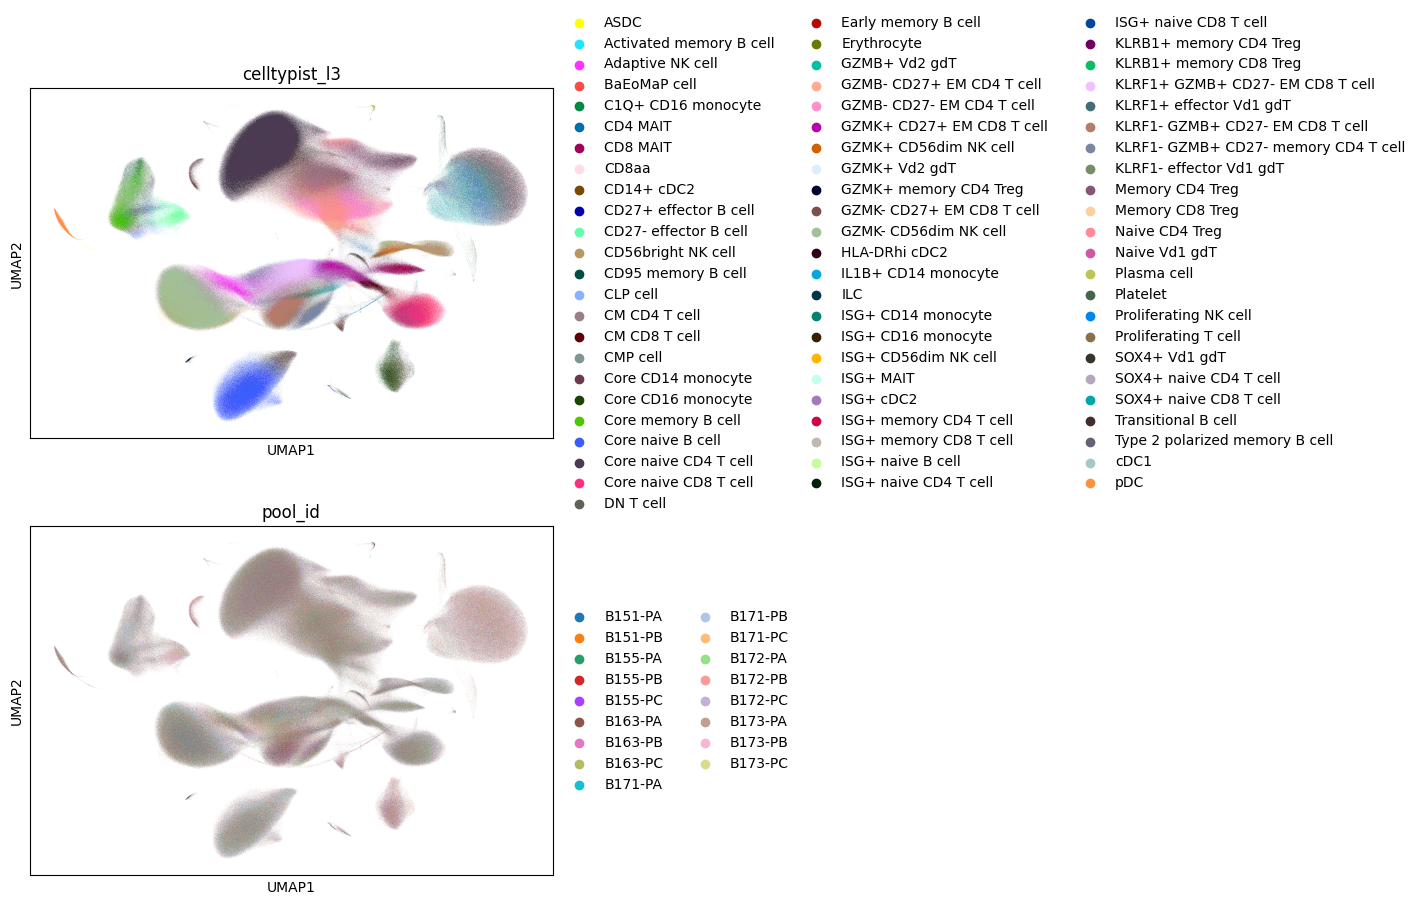

In [3]:
sc.pl.umap(adata, color=['celltypist_l3','pool_id'], ncols=1)

In [4]:

def swap_dict_values(d):
    keys = list(d.keys())
    values = list(d.values())
    random.shuffle(values)
    return dict(zip(keys, values))
    
def gen_mpl_labels(adata, groupby, exclude=(), ax=None, adjust_kwargs=None, text_kwargs=None):
    if adjust_kwargs is None:
        adjust_kwargs = {"text_from_points": False}
    if text_kwargs is None:
        text_kwargs = {}

    highest_density_points = {}

    for g, g_idx in adata.obs.groupby(groupby).groups.items():
        if g in exclude:
            continue
        points = adata[g_idx].obsm["X_umap"]
        hist, xedges, yedges = np.histogram2d(points[:, 0], points[:, 1], bins=[50, 50])
        max_bin = np.unravel_index(np.argmax(hist), hist.shape)
        highest_density_point = [(xedges[max_bin[0]] + xedges[max_bin[0]+1])/2, 
                                 (yedges[max_bin[1]] + yedges[max_bin[1]+1])/2]
        highest_density_points[g] = highest_density_point

    if ax is None:
        texts = [
            plt.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in highest_density_points.items()]
    else:
        texts = [ax.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in highest_density_points.items()]

    adjust_text(texts, **adjust_kwargs)

In [8]:
adata.obs.index=adata.obs['barcodes'].tolist()

In [11]:
from adjustText import adjust_text


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/tmp/ipykernel_47033/2563822490.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observe

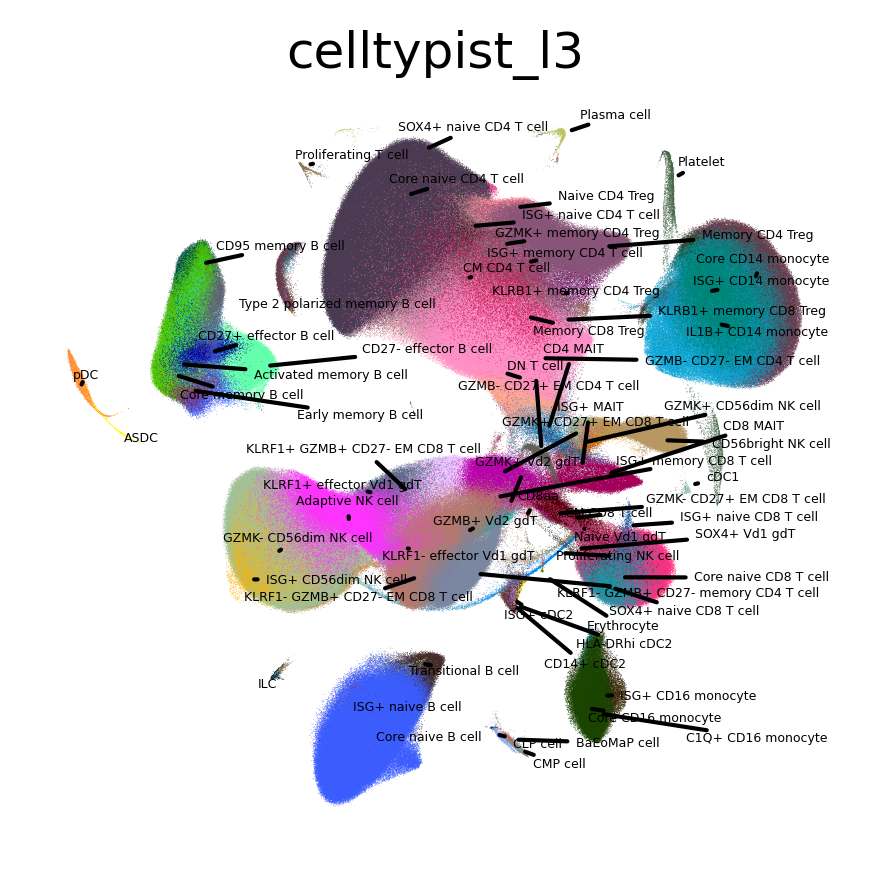

In [12]:
with plt.rc_context({"figure.figsize": (3, 3), "figure.dpi": 300, "figure.frameon": False}):
    ax=sc.pl.umap(adata, color=['celltypist_l3'], size=0.1,show=False,legend_loc=None,ncols=1 ,frameon=False)
    gen_mpl_labels(
        adata,
        "celltypist_l3",
        exclude=(""),  
        ax=ax,
        adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
        text_kwargs=dict(fontsize=3),)
    fig = ax.get_figure()
    fig.tight_layout()
    

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ve

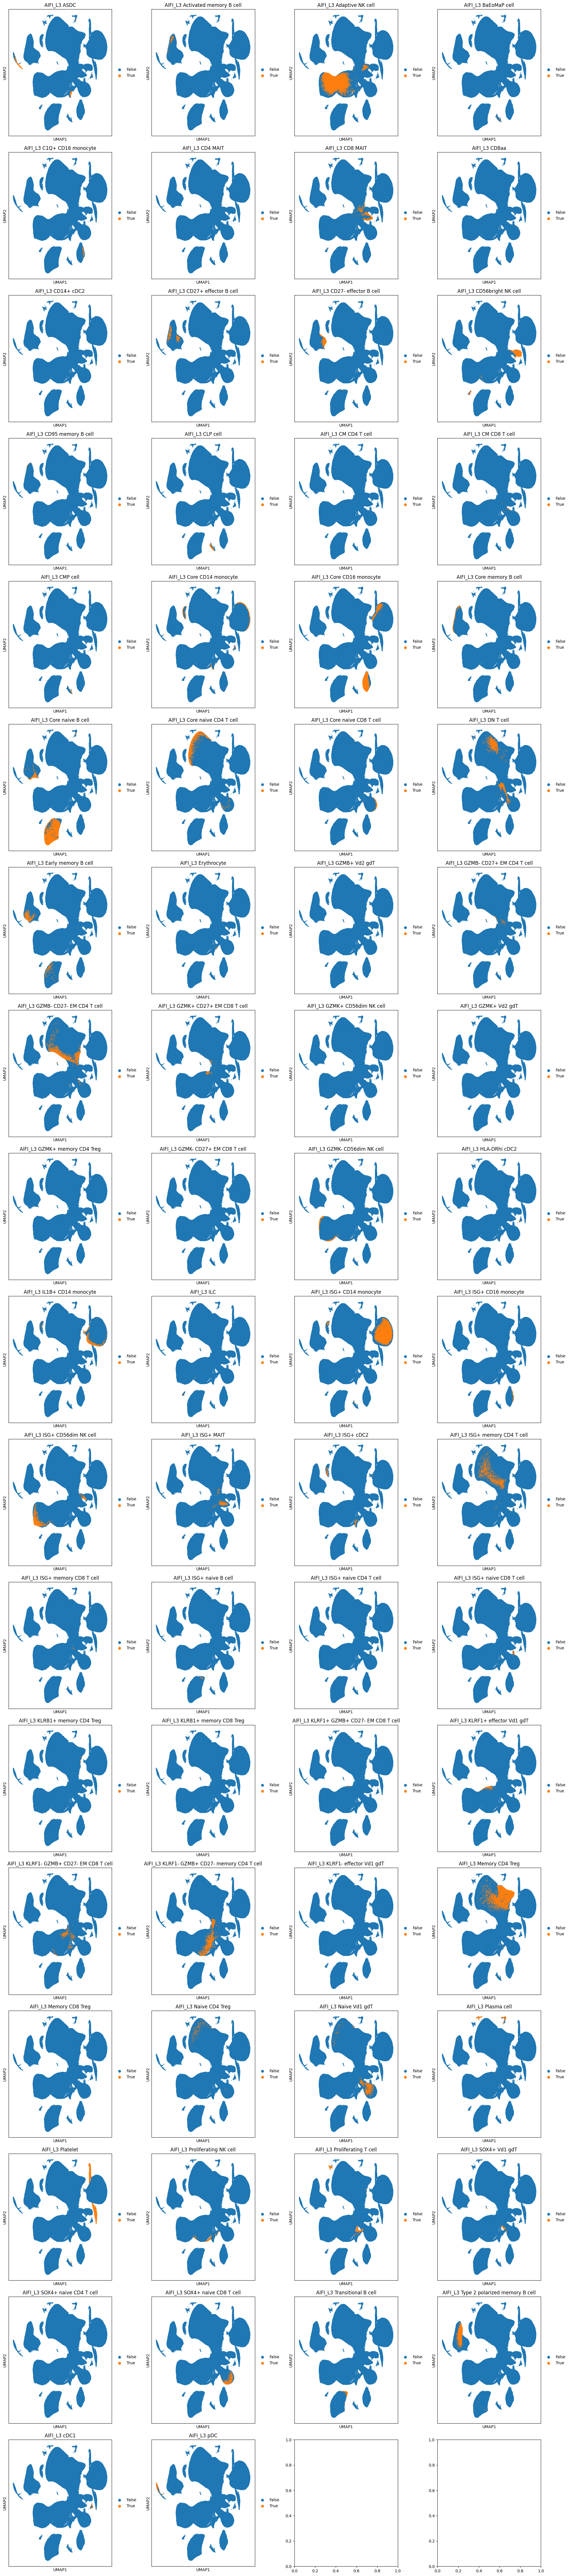

In [13]:
import math
AIFI_L3_categories = adata.obs['celltypist_l3'].cat.categories

n_categories = len(AIFI_L3_categories)

n_columns = 4
n_rows = math.ceil(n_categories / n_columns)

fig, axs = plt.subplots(n_rows, n_columns, figsize=(5 * n_columns, 5 * n_rows))

for i, category in enumerate(AIFI_L3_categories):
    row = i // n_columns
    col = i % n_columns
    adata.obs['cluster_dummy'] = adata.obs['celltypist_l3'] == category
    adata.obs['cluster_dummy'] = [str(item) for item in adata.obs['cluster_dummy']]
    sc.pl.umap(adata, 
               color='cluster_dummy', 
               title=f'AIFI_L3 {category}',
               ax=axs[row, col], show=False,size=10)  

plt.tight_layout()
plt.show()

In [ ]:
%%time
tasks = [(1, "leiden_resolution_1"),(1.5, "leiden_resolution_1.5"),(2, "leiden_resolution_2")]
adata = run_leiden_parallel(adata, tasks)

In [ ]:
adata=adata.raw.to_adata()

In [ ]:
adata.write_h5ad('All_leiden.h5ad')